In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_014.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_093.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_051.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_028.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_065.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_004.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_013.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_070.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_095.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_053.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_073.jpg
/kaggle/input/papaya-classification/papaya_image/papaya_image/mature/Mature_

# Importing Libraries

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load Images

In [3]:
def load_images_from_folder(folder, label, size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, size)
            print("Loaded image shape:", img.shape)  # Check image shape
            images.append(img.flatten())
            labels.append(label)
    return images, labels


# Load Datasets

In [4]:
def load_dataset(base_path):
    categories = os.listdir(base_path)
    print("Categories:", categories)  # Print categories to verify
    X = []
    y = []
    for label, category in enumerate(categories):
        folder = os.path.join(base_path, category)
        images, labels = load_images_from_folder(folder, label)
        X.extend(images)
        y.extend(labels)
    return np.array(X), np.array(y), categories


In [5]:
base_path = '/kaggle/input/papaya-classification/papaya_image/papaya_image'  # Update with your dataset path
X, y, categories = load_dataset(base_path)

Categories: ['mature', 'partiallymature', 'unmature']
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape: (64, 64)
Loaded image shape

In [6]:
print(X, y, categories)

[[140 141 140 ... 200 198 200]
 [206 206 207 ... 180 183 181]
 [192 191 191 ... 150 149 154]
 ...
 [186 186 186 ... 155 157 160]
 [190 190 189 ... 186 184 179]
 [195 194 194 ... 146 148 152]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2] ['mature', 'partiallymature', 'unmature']


In [7]:
print("Number of samples:", len(X))  

Number of samples: 300


# Data Visualization

In [8]:
def show_sample_images(images, labels, categories, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(64, 64))
        plt.title(categories[labels[i]])
        plt.axis('off')
    plt.show()

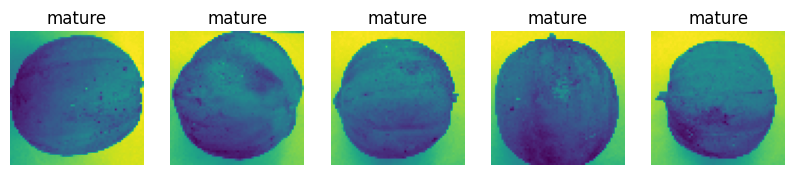

In [9]:
show_sample_images(X, y, categories)

# Train Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Model and train by the training set

In [11]:
pipeline = make_pipeline(StandardScaler(), svm.SVC(kernel='linear'))
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

# make prediction

In [12]:
y_pred = pipeline.predict(X_test)

# Evaluation

## classification report

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))


Classification Report:
                 precision    recall  f1-score   support

         mature       1.00      1.00      1.00        22
partiallymature       1.00      1.00      1.00        16
       unmature       1.00      1.00      1.00        22

       accuracy                           1.00        60
      macro avg       1.00      1.00      1.00        60
   weighted avg       1.00      1.00      1.00        60



## confusion matrix

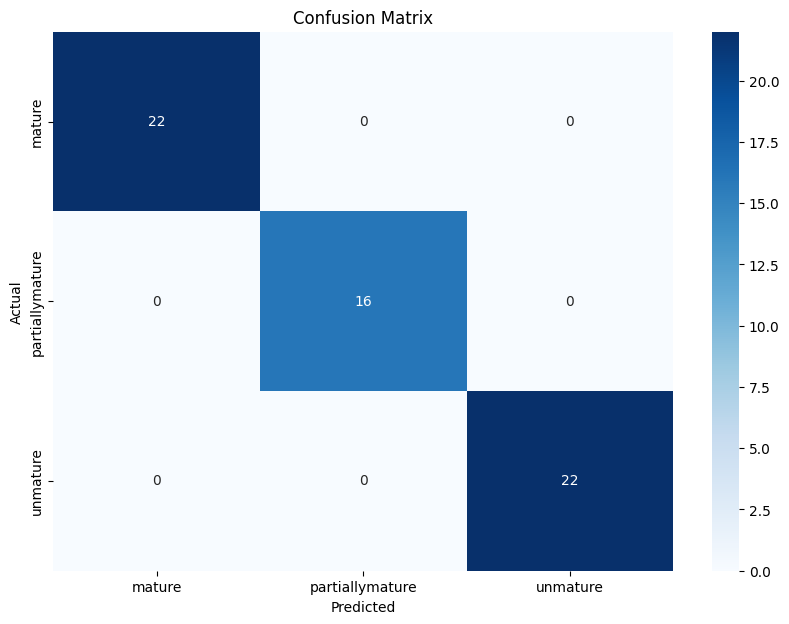

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## accuracy

In [15]:
accuracy = pipeline.score(X_test, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%
